In [1]:
import torch.nn as nn
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import time
import csv

In [2]:
def log_loss(epoch, loss, filename="training_log.csv"):
    file_exists = os.path.isfile(filename)
    with open(filename, 'a', newline='') as csvfile:
        fieldnames = ['epoch', 'loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        if not file_exists:
            writer.writeheader()

        writer.writerow({'epoch': epoch, 'loss': loss})

In [3]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           valid_size=0.1,
                           shuffle=True):

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # Common transform for both train and validation (since you already augmented externally)
    base_transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        normalize,
    ])

    # Load dataset from folders
    dataset = datasets.ImageFolder(
        root=data_dir,
        transform=base_transform
    )

    num_train = len(dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(
        dataset, batch_size=batch_size, sampler=train_sampler
    )

    valid_loader = DataLoader(
        dataset, batch_size=batch_size, sampler=valid_sampler
    )

    return train_loader, valid_loader


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485],  # grayscale → single mean
        std=[0.229],  # grayscale → single std
    )

    # define transform for test set
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # ensure 3-channel
        transforms.Resize((48, 48)),                 # match model input
        transforms.ToTensor(),
        normalize,
    ])

    # load your custom dataset (expects folder per class)
    dataset = datasets.ImageFolder(
        root=data_dir,
        transform=transform
    )

    # wrap in DataLoader
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle
    )

    return data_loader

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [5]:
class AlexNetModifiedFER2013(nn.Module):
    def __init__(self, num_classes=7):
        super(AlexNetModifiedFER2013, self).__init__()
        # input size = 1x48x48

        # output size convotion = (\frac{input - kernel + 2 * padding}{stride})+1
        # output size maxpool = (\frac{input - kernel}{stride})+1

        self.layer1 = nn.Sequential(
            # input greyscale with 48x48
            nn.Conv2d(3, 96, kernel_size=4, stride=2, padding=0),
            # (48 - 4 + (2*0) / 2 + 1
            # 23
            # output 96 channel, 23 width, 23 height

            # input 96 channel, 23 width, 23 height
            nn.BatchNorm2d(96),
            # output 96 channel, 23 width, 23 height

            # input 96 channel, 23 width, 23 height
            nn.ReLU(),
            # output 96 channel, 23 width, 23 height

            # input 96 channel, 23 width, 23 height
            nn.MaxPool2d(kernel_size=3, stride=2)
            # output 96 channel, 11 width, 11 height
        )
        self.layer2 = nn.Sequential(
            # input 96 channel, 11 width, 11 height
            nn.Conv2d(96, 256, kernel_size=4, stride=1, padding=2),
            # (11 - 4 + (2*2) / 1) + 1
            # 12
            # output 256 channel, 12 width, 12 height

            # input 256 channel, 12 width, 12 height
            nn.BatchNorm2d(256),
            # output 256 channel, 12 width, 12 height

            # input 256 channel, 12 width, 12 height
            nn.ReLU(),
            # output 256 channel, 12 width, 12 height

            # input 256 channel, 12 width, 12 height
            nn.MaxPool2d(kernel_size=4, stride=2)
            # ((12 - 4) / 2) + 1
            # 5
            # output 256 channel, 5 width, 5 height
        )

        # flatten channel 256 * 5 * 5 = 6400
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(6400, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        # Feature extractor
        out = self.layer1(x)
        out = self.layer2(out)

        # Flatten for fully connected layers
        out = out.reshape(out.size(0), -1)

        # The NN for classifier
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [6]:
# Hyper Parameter
num_classes = 7
num_epochs = 100
batch_size = 12_288
learning_rate = 1e-2

In [7]:
# Data Loader
train_loader, valid_loader = get_train_valid_loader(
    data_dir=os.path.join(os.getcwd(), 'augmented_dataset', 'train'),
    batch_size=batch_size
)

test_loader = get_test_loader(
    data_dir=os.path.join(os.getcwd(), 'dataset', 'test'),
    batch_size=batch_size
)


In [8]:
# Load model with random parameters
model = AlexNetModifiedFER2013(num_classes).to(device)

model

AlexNetModifiedFER2013(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6400, out_features=4096, bias=True)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=4096, out_features=7, bias=True)
  )
)

In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate, weight_decay=5e-3, momentum=0.9)


In [10]:
# Train the model
total_step = len(train_loader)

# Train
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(
        f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
    log_loss(epoch=epoch+1, loss=loss.item(), filename='loss_log.csv')

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        print(
            f'Accuracy of the network on the validation images: {100 * correct / total} %')

        # this logs accuracy
        log_loss(epoch=epoch+1, loss=100 * correct / total, filename='val_log.csv')
        
        if epoch % 10 == 0:
            torch.save(
                model, f'./AlexNetModifiedFER2013_weights_{str(time.time())}.pth')


Epoch [1/100], Step [22/22], Loss: 1.8643
Accuracy of the network on the validation images: 23.91934677553741 %
Epoch [2/100], Step [22/22], Loss: 1.8486
Accuracy of the network on the validation images: 24.52591234794201 %
Epoch [3/100], Step [22/22], Loss: 1.8507
Accuracy of the network on the validation images: 24.832527912014665 %
Epoch [4/100], Step [22/22], Loss: 1.8414
Accuracy of the network on the validation images: 25.14580903182803 %
Epoch [5/100], Step [22/22], Loss: 1.8340
Accuracy of the network on the validation images: 25.219130144975836 %
Epoch [6/100], Step [22/22], Loss: 1.8301
Accuracy of the network on the validation images: 26.128978503582736 %
Epoch [7/100], Step [22/22], Loss: 1.8301
Accuracy of the network on the validation images: 26.45559073487752 %
Epoch [8/100], Step [22/22], Loss: 1.8186
Accuracy of the network on the validation images: 26.525579070154976 %
Epoch [9/100], Step [22/22], Loss: 1.8189
Accuracy of the network on the validation images: 27.31544

In [11]:
# Validate

In [12]:
test_loader = get_test_loader(
    data_dir=os.path.join(os.getcwd(), 'dataset', 'test'),
    batch_size=batch_size
)

Accuracy of the network on the 10000 test images: 50.2646976873781 %
Overall Test Accuracy: 50.26%

Classification Report:
              precision    recall  f1-score   support

       angry       0.39      0.30      0.34       958
     disgust       0.24      0.38      0.29       111
        fear       0.43      0.11      0.17      1024
       happy       0.56      0.87      0.69      1774
     neutral       0.43      0.53      0.48      1233
         sad       0.43      0.34      0.38      1247
    surprise       0.69      0.65      0.67       831

    accuracy                           0.50      7178
   macro avg       0.45      0.45      0.43      7178
weighted avg       0.49      0.50      0.47      7178

Confusion Matrix:


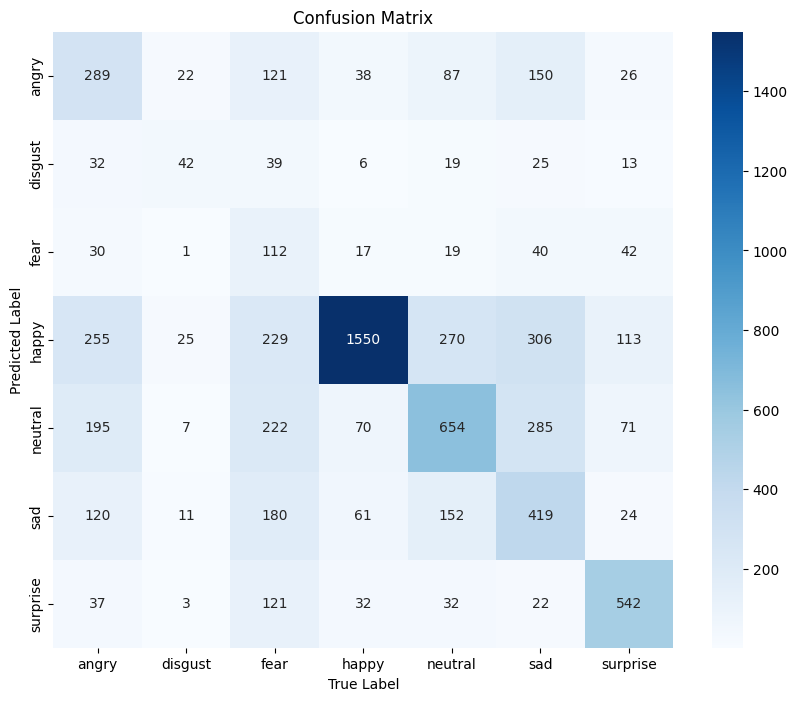

In [18]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

# Test
# Disable dropout and grad
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(
        10000, 100 * correct / total))

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

accuracy = accuracy_score(all_labels, all_preds)
print(f"Overall Test Accuracy: {accuracy * 100:.2f}%\n")

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

print("Confusion Matrix:")
cm = confusion_matrix(all_preds, all_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Predicted Label')
plt.xlabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('./from_stratch_eval_matrix_inverted.png')
plt.show()